In [4]:
# rimuovo roba per semplicità
NYC_small = NYC_nona.drop(['passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'fare_amount',
                 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 
                 'congestion_surcharge'], axis=1)
NYC_small 

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,238,239
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,239,238
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,238,238
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,238,151
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,193,193
...,...,...,...,...,...
6339562,2.0,2020-01-31 23:38:07,2020-01-31 23:52:21,163,246
6339563,2.0,2020-01-31 23:00:18,2020-01-31 23:19:18,164,79
6339564,2.0,2020-01-31 23:24:22,2020-01-31 23:40:39,79,68
6339565,2.0,2020-01-31 23:44:22,2020-01-31 23:54:00,100,142


In [5]:
# elimino il trip che arriva dopo la partenza
NYC_small = NYC_small[NYC_small['tpep_dropoff_datetime'] >= NYC_small['tpep_pickup_datetime']]

In [6]:
# due cope del dataset originale
df1 = NYC_small.copy()
df2 = NYC_small.copy()


In [7]:
# creo una colonna in comune per i due dataset per fare il merge, con df1 indico il dataset "left" mentre con df2
# indico il dataset "right"
df1['LocationID'] = df1['DOLocationID']
df2['LocationID'] = df2['PULocationID']


In [8]:
df1.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,LocationID
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,238,239,239
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,239,238,238
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,238,238,238
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,238,151,151
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,193,193,193


In [9]:
# salvo gli indici del dataset originale in una colonna, trip_id_left per df1 e trip_id_right per il df2
# (questo serve perchè facendo il merge perdo gli indici originali)
df1 = df1.reset_index(drop=False).rename(columns={'index': 'trip_id_left'})
df2 = df2.reset_index(drop=False).rename(columns={'index': 'trip_id_right'})


In [10]:
df1.head()

,trip_id_left,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,LocationID
0,0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,238,239,239
1,1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,239,238,238
2,2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,238,238,238
3,3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,238,151,151
4,4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,193,193,193


In [11]:
# sorto i due dataset in base alla chiave per cui voglio fare il merge (left_on e right_on), inoltre ordino anche per
# vendorID, per LocationID e per non creare casualità anche per l'orario opposto a quello considerato per il merge
df1 = df1.sort_values(by=['tpep_dropoff_datetime', 'VendorID', 'LocationID', 'tpep_pickup_datetime']).reset_index(drop=True)
df2 = df2.sort_values(by=['tpep_pickup_datetime', 'VendorID', 'LocationID', 'tpep_dropoff_datetime']).reset_index(drop=True)


In [12]:
df1.head()

,trip_id_left,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,LocationID
0,782435,2.0,2003-01-01 00:07:17,2003-01-01 14:16:59,193,193,193
1,3136556,2.0,2008-12-31 23:17:15,2008-12-31 23:32:32,162,263,263
2,3136557,2.0,2008-12-31 23:35:00,2008-12-31 23:36:53,263,263,263
3,3392619,2.0,2008-12-31 23:06:13,2008-12-31 23:37:14,144,230,230
4,3136558,2.0,2008-12-31 23:39:37,2008-12-31 23:55:35,263,143,143


In [13]:
# E' un tipo di merge che permette di inserire una soglia di tolleranza. In questo caso uniamo il df1 e df2 in modo che
# ad ogni riga del df1 vengano aggiunti i trip che si collegano ad esso (dobbiamo pensarlo come una sorta di left join). 
# Le condizioni per cui due trip si colleghino sono che:
# 1) il drop off del df1 (da sinistra) sia "uguale" al pickup del df1 (da destra), le virgolette sull'uguale ci vanno
# perchè è possibile impostare una soglia di tolleranza che mettiamo uguale a 2 minuti. Impostare direction = 'forward'
# toglie la possibilità di collegare trip con differenza di tempo <0, dato che li ordina.
#
# 2) con by=['VendorID', 'LocationID'] ci assicuriamo che anche il VendorID debba essere uguale, e che abbiano la stessa 
# LocationID (questo funziona perchè df1 considera la DOL, mentre il df1 la PUL, e qua stiamo praticamente aggiungendo df2 a df1)
# 
# La parte dei suffixes serve per dopo, dato che il merge produrrà colonne con lo stesso nome, ma con l'aggiunta di _left per
# quelle di df1 e _right per quelle di df2

df_merged = pd.merge_asof(
    df1,
    df2,
    left_on='tpep_dropoff_datetime',
    right_on='tpep_pickup_datetime',
    by=['VendorID', 'LocationID'],
    tolerance=pd.Timedelta('2min'),
    allow_exact_matches=True,
    direction='forward',
    suffixes=('_left', '_right')
)


In [14]:
# Se una riga ha degli NA significa che quel trip non ha "trovato" nessun trip che si potesse collegare
df_merged.head()

,trip_id_left,VendorID,tpep_pickup_datetime_left,tpep_dropoff_datetime_left,PULocationID_left,DOLocationID_left,LocationID,trip_id_right,tpep_pickup_datetime_right,tpep_dropoff_datetime_right,PULocationID_right,DOLocationID_right
0,782435,2.0,2003-01-01 00:07:17,2003-01-01 14:16:59,193,193,193,NaN,NaT,NaT,NaN,NaN
1,3136556,2.0,2008-12-31 23:17:15,2008-12-31 23:32:32,162,263,263,NaN,NaT,NaT,NaN,NaN
2,3136557,2.0,2008-12-31 23:35:00,2008-12-31 23:36:53,263,263,263,NaN,NaT,NaT,NaN,NaN
3,3392619,2.0,2008-12-31 23:06:13,2008-12-31 23:37:14,144,230,230,NaN,NaT,NaT,NaN,NaN
4,3136558,2.0,2008-12-31 23:39:37,2008-12-31 23:55:35,263,143,143,NaN,NaT,NaT,NaN,NaN


In [15]:
# il problema del df_merged sopra è che ad un trip del df1, si potrebbero collegare più trip del df2.
# Esempio: trip1 parte da zona * alle **:**:** e arriva alla zona 10 alle 10:00:00
#          trip2 parte da zona 10 alle 10:01:10 e arriva alla zona * alle **:**
#          trip3 parte da zona 10 alle 10:01:50 e arriva alla zona * alle **:**
# in questo caso sia trip2 che trip3 vengono collegati al trip1 (ma in due righe diverse).
# Per risolvere questo problema ordiniamo il dataset per trip_id_left, ovvero quello di partenda, e per l'orario di pickup del trip ad esso collegato.
# Esempio df_merged:
# (trip1,...) (trip2,...,PUTime: 10:01:10)
# (trip3,...) (trip4,...)
# (trip6,...) (trip10,...)
# (trip1,...) (trip3,...,PUTime: 10:01:50)
# Ordinandolo per trip1, e per PUTime del secondo trip, possiamo rimuovere i duplicati di trip1 mantenendo solo il primo, e questo è
# quello che fanno le due righe sotto:
df_merged = df_merged.sort_values(by=['trip_id_left', 'tpep_pickup_datetime_right'])
df_merged = df_merged.drop_duplicates(subset='trip_id_left', keep='first')


In [16]:
# Teniamo solamente le due colonne che indicano gli id dei trip e rimuoviamo tutti gli NA (e le variabili sugli orari che non ci servono più)
# (quello che dovremo fare dopo è assegnare dei valori alle chain e unire i viaggi ad altre chain (per creare chain da più di due viaggi)
df_edges = df_merged[['trip_id_left', 'trip_id_right']].dropna()

# questo è solo per avere degli interi per i confronti sono più comodi
df_edges['trip_id_left'] = df_edges['trip_id_left'].astype(int)
df_edges['trip_id_right'] = df_edges['trip_id_right'].astype(int)


In [17]:
# dataframe con le coppie di trip_id che fanno da chain (ora però vanno collegate, se possibile)
df_edges.head()

,trip_id_left,trip_id_right
3470,0,3590
5687,1,10437
8269,2,4965
9737,3,14784
30,7,8


In [18]:
# in pratica : 1) creare il diz, 2) preparare dati, 3) si fanno le catene,
# 4) si assegnano degli Id alle catene


# (df_edges contiene coppie di viaggi collegati con due colonne, id del left e id del right.
# set_index mette il trip_id_left come index per permettere un accesso rapido al diz,
# che avrà appunto trip_id_left come chiave e trip_id_right come valore.
# (.to_dict() trasforma il risultato del set_index in un dizionario)
edges_dict = df_edges.set_index('trip_id_left')['trip_id_right'].to_dict()

# questo diz ci serve per associare ogni trip id al suo chain id
chains = {}
# questo set ci serve per tenere traccia di quali trip sono già stati controllati
visited = set()

# ciclo per ogni viaggio che ha un collegamento (dato che è in df_edges avrà un collegamento, altrimenti
# sarebbe già stato eliminato quando abbiamo droppato gli NA)
for trip_left in df_edges['trip_id_left'].unique(): #l'unique è per considerare ogni trip_id una volta
    if trip_left in visited:
        continue  # se il trip è già stato controllato skippiamo

    chain_id = trip_left # la chain_id sarà il trip_id del trip a sinistra (che sarebbe il primo viaggio)
    chain = [trip_left] # in questo modo iniziamo una nuova catena con questo viaggio 
                        # (è una lista con dentro le info sui viaggi di quella chain)
    visited.add(trip_left) # aggiungiamo qua il viaggio per segnarci che è stato già controllato
    current_trip_id = trip_left # serve per tenere conto di quale trip stiamo considerando dentro al while

    # l'obiettivo è quello di allungare la catena finchè c'è un viaggio che si può collegare
    # al current_trip_id (in pratica facciamo una catena alla volta) 
    # controlliamo se ci sono connessioni tra viaggi tramite edges_dict, che ha le info sulle coppie
    while current_trip_id in edges_dict:
        next_trip_id = edges_dict[current_trip_id] # richiamando la chiave del current_trip_id, ci restituisce
                                                   # il trip_id del viaggio ad esso collegato, aka next_trip_id
        # controlliamo se il next_trip è già stato controllato, ed in caso si esce dal ciclo
        if next_trip_id in visited:
            break
        # in caso non sia ancora stato controllato, lo aggiungiamo con .append alla lista chain (fatta prima)
        # ad esempio se chain è [2,14], ed il next_trip è 18, diventerà [2,14,18]
        chain.append(next_trip_id)
        visited.add(next_trip_id) # lo aggiungiamo per non farlo controllare di nuovo
        current_trip_id = next_trip_id #aggiornaimo il current_trip con il next, così che al passo dopo,
                                       # controllerà il "next_trip del next_trip" e così via, finchè
                                       # non ci saranno altri viaggi collegati al current_trip e si chiude il 
                                       # ciclo while (concludendo la catena)

    # assegna lo stesso chain_id a tutti i trip della stessa chain, il chain_id di ogni chain
    # si riferisce al trip_id del primo viaggio della chain.
    for trip_id in chain:
        chains[trip_id] = chain_id


In [19]:
NYC_small = NYC_small.copy() # si crea una copia senno questo codice sotto rompe ì cazzo

# questo serve per creare la colonna chain nel dataset originale, ricordandosi dei trip_id e matchandoli 
# con l'index. .map applica la funzione tra parentesi a tutto il dataframe.
# (lambda x: chains.get(x, x)) è una funzione che prende in input x e restituisce chains.get(x,x), nel 
# nostro caso chains è il dizionario con tutti i trip_id e le chain_id. (è come se stesse facendo .get(key, default)
# e praticamente cerca il numero di index (=trip_id) nel dizionario chains. Se x (=trip_id) è una chiave in chains,
# allora assegna a quel trip nella colonna df['chain'] il valore chains[x] (che sarebbe l'ID della catena a cui appartiene il viaggio)
# Se invece x (=trip_id o index) non è una chiave nel dizionario chains, allora assegna a df['chain'] il valore x stesso (cioè il trip_id).
NYC_small['chain'] = NYC_small.index.map(lambda x: chains.get(x, x))


In [20]:
NYC_small['chain'].nunique() # numero di chain 3986631

3986631

In [21]:
NYC_small.sort_values(['chain','tpep_pickup_datetime']).head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,chain
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,238,239,0
3590,1.0,2020-01-01 00:33:41,2020-01-01 00:40:46,239,244,0
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,239,238,1
10437,1.0,2020-01-01 00:43:31,2020-01-01 01:01:34,238,141,1
25565,1.0,2020-01-01 01:01:38,2020-01-01 01:05:37,141,263,1


In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

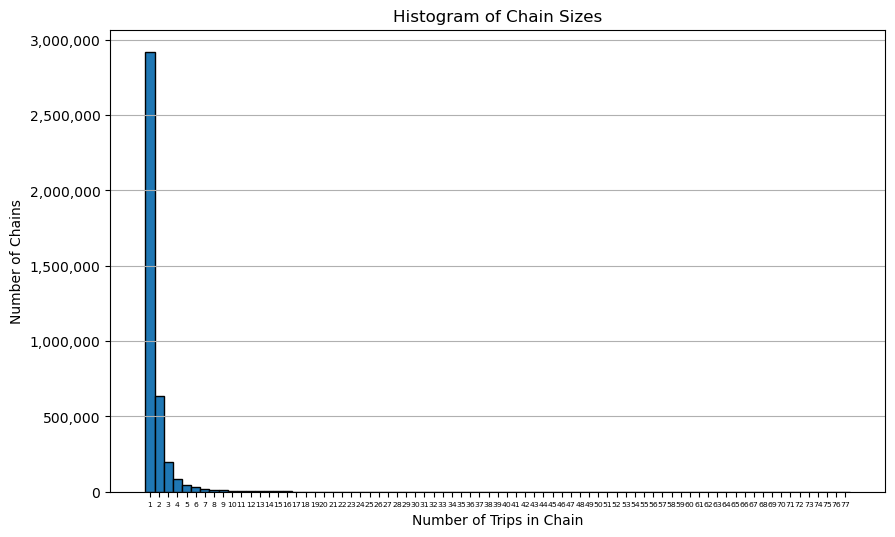

In [23]:
chain_trip_counts = NYC_small['chain'].value_counts()

plt.figure(figsize=(10, 6))
bins = range(1, chain_trip_counts.max() + 2)
plt.hist(chain_trip_counts, bins=bins, align='left', edgecolor='black')
plt.title('Histogram of Chain Sizes')
plt.xlabel('Number of Trips in Chain')
plt.ylabel('Number of Chains')
plt.xticks(range(1, chain_trip_counts.max() + 1))
plt.grid(axis='y')
plt.tick_params(axis='x', which='major', labelsize=5.5)

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [51]:
longest_chain_id = chain_trip_counts.idxmax()
longest_chain_size = chain_trip_counts.max()
print(longest_chain_id, longest_chain_size)

1268970 77


In [61]:
chain_1268970 = NYC_small[NYC_small['chain'] == 1268970]
chain_1268970.sort_values(by='tpep_pickup_datetime').head(20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,chain
1268970,2.0,2020-01-08 09:09:58,2020-01-08 09:16:35,237,236,1268970
1274776,2.0,2020-01-08 09:16:37,2020-01-09 08:54:13,236,170,1268970
1473128,2.0,2020-01-09 08:54:22,2020-01-09 09:11:07,170,161,1268970
1491290,2.0,2020-01-09 09:11:19,2020-01-09 09:20:53,161,164,1268970
1489585,2.0,2020-01-09 09:20:53,2020-01-09 09:30:44,164,233,1268970
1486622,2.0,2020-01-09 09:31:09,2020-01-09 09:31:18,233,233,1268970
1481777,2.0,2020-01-09 09:31:27,2020-01-09 09:47:07,233,140,1268970
1484881,2.0,2020-01-09 09:47:11,2020-01-09 10:04:33,140,230,1268970
1501506,2.0,2020-01-09 10:04:43,2020-01-09 10:14:23,230,48,1268970
1500773,2.0,2020-01-09 10:14:37,2020-01-09 10:21:50,48,68,1268970
